# Rolling Mean Replacement

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from   sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In this case using a forward rolling moving average approach to filling missing data. The most important part to see how cleaning methods affect results. While there are many ways of measuring this but the main will be measuring the sharpe vs. the moving average window. 

In [4]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryInflationPCA\root\src")
sys.path.append(r"/Users/diegoalvarez/Desktop/research/TreasuryInflationPCA/root/src")
from CollectData import DataManager

## Baseline Results

In this case run results with holes in it and then measure sharpe. 

In [7]:
def _get_pca(df: pd.DataFrame) -> pd.DataFrame: 

    df_wider = (df.drop(
        columns = ["Description"]).
        pivot(index = "date", columns = "security", values = "value").
        dropna())
    
    data = (pd.DataFrame(
        data    = PCA(n_components = 3).fit_transform(df_wider),
        index   = df_wider.index,
        columns = ["PC{}".format(i + 1) for i in range(3)]).
        reset_index().
        melt(id_vars = "date"))

    return data

In [8]:
def _lag_siganl(df: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df.sort_values(
        "date").
        assign(lag_signal = lambda x: x.spread.shift()))

    return df_out

def get_baseline_sharpe() -> pd.DataFrame: 

    df_inflation, df_breakeven = DataManager().get_inflation_swap(), DataManager().get_breakeven()
    
    df_sharpe = (pd.concat([
        _get_pca(df_inflation).assign(curve = "inflation"),
        _get_pca(df_breakeven).assign(curve = "breakeven")]).
        pivot(index = ["date", "variable"], columns = "curve", values = "value").
        dropna().
        reset_index().
        assign(spread = lambda x: x.breakeven - x.inflation).
        groupby("variable").
        apply(_lag_siganl, include_groups = False).
        reset_index().
        drop(columns = ["level_1"]).
        dropna()
        [["date", "variable", "lag_signal"]].
        merge(right = DataManager().get_tsy_fut(), how = "inner", on = ["date"]).
        drop(columns = ["PX_LAST", "PX_dur", "PX_cnvx", "PX_rtn", "PX_diff"]).
        assign(
            security   = lambda x: x.security.str.split(" ").str[0],
            signal_rtn = lambda x: np.sign(x.lag_signal) * x.PX_bps)
        [["variable", "security", "signal_rtn"]].
        groupby(["variable", "security"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn", 
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        reset_index())

    return df_sharpe

df_baseline = get_baseline_sharpe()

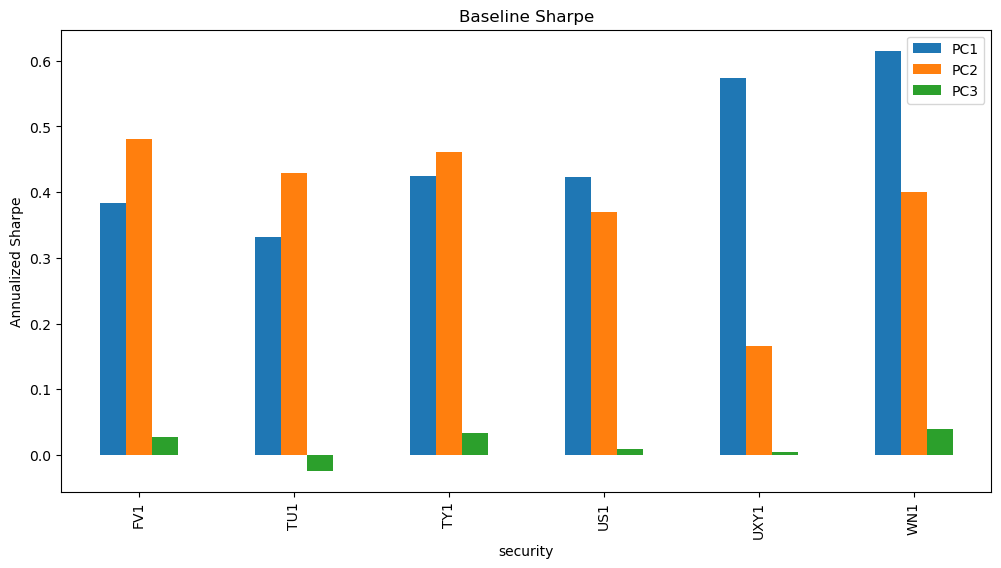

In [9]:
def plot_baseline_sharpe(df_baseline: pd.DataFrame) -> plt.Figure: 

    (df_baseline.rename(
        columns = {"variable": ""}).
        pivot(index = "security", columns = "", values = "sharpe").
        plot(
            kind    = "bar",
            ylabel  = "Annualized Sharpe",
            title   = "Baseline Sharpe",
            figsize = (12,6)))

plot_baseline_sharpe(df_baseline)

## Rolling EWMA

In [11]:
def _fill_na(df: pd.DataFrame, window: int) -> pd.DataFrame: 

    df_out = (df.assign(
        roll_mean = lambda x: x.value.rolling(window = window).mean(),
        value     = lambda x: np.where(x.value != 0, x.roll_mean, x.value)).
        drop(columns = ["roll_mean"]))

    return df_out

def roll_mean_clean(df: pd.DataFrame, window: int = 2) -> pd.DataFrame: 
    
    df_out = (df.drop(
        columns = ["Description"]).
        pivot(index = "date", columns = "security", values = "value").
        reset_index().
        melt(id_vars = "date").
        assign(value = lambda x: x.value.fillna(0)).
        groupby("security").
        apply(_fill_na, window, include_groups = False).
        reset_index().
        drop(columns = ["level_1"]).
        assign(Description = "").
        dropna())

    return df_out

In [12]:
def _get_roll_mean_sharpe(window: int) -> pd.DataFrame: 
    
    df_inflation = roll_mean_clean(DataManager().get_inflation_swap(), window)
    df_breakeven = roll_mean_clean(DataManager().get_breakeven(), window)
    
    df_sharpe = (pd.concat([
        _get_pca(df_inflation).assign(curve = "inflation"),
        _get_pca(df_breakeven).assign(curve = "breakeven")]).
        pivot(index = ["date", "variable"], columns = "curve", values = "value").
        dropna().
        reset_index().
        assign(spread = lambda x: x.breakeven - x.inflation).
        groupby("variable").
        apply(_lag_siganl, include_groups = False).
        reset_index().
        drop(columns = ["level_1"]).
        dropna()
        [["date", "variable", "lag_signal"]].
        merge(right = DataManager().get_tsy_fut(), how = "inner", on = ["date"]).
        drop(columns = ["PX_LAST", "PX_dur", "PX_cnvx", "PX_rtn", "PX_diff"]).
        assign(
            security   = lambda x: x.security.str.split(" ").str[0],
            signal_rtn = lambda x: np.sign(x.lag_signal) * x.PX_bps)
        [["variable", "security", "signal_rtn"]].
        groupby(["variable", "security"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn", 
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        reset_index().
        assign(window = window))

    return df_sharpe

In [13]:
windows = list(range(10, 501, 5))
df_out  = pd.concat([_get_roll_mean_sharpe(window) for window in windows])

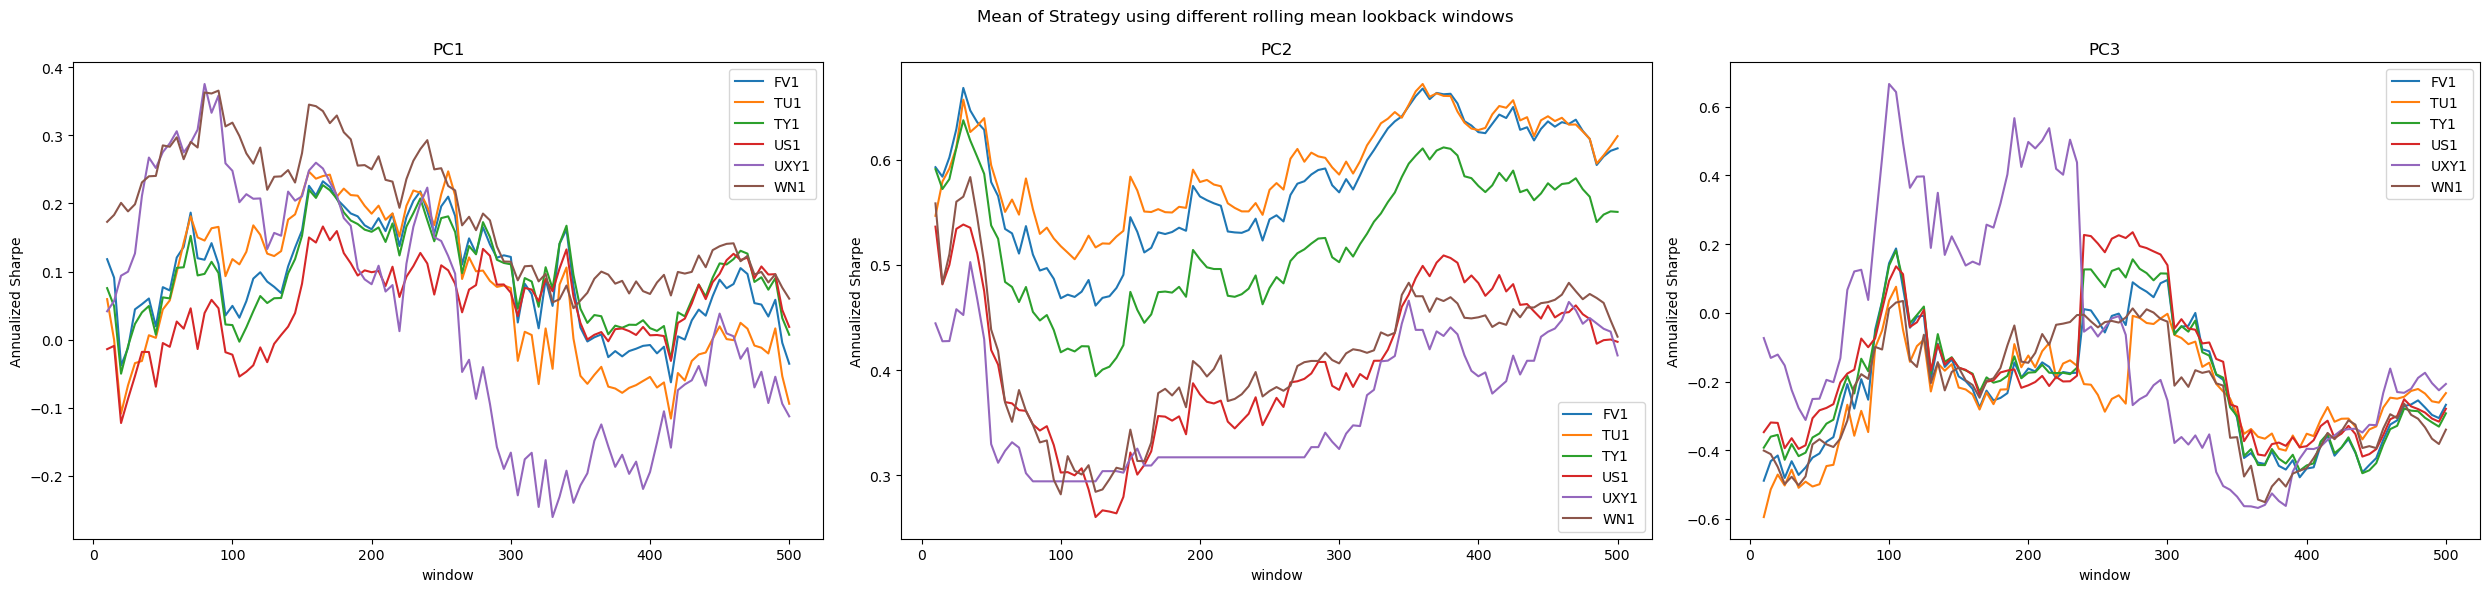

In [14]:
def plot_rolling_sharpe(df_out: pd.DataFrame) -> plt.Figure: 

    variables = df_out.variable.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (25,6))
    
    for variable, ax in zip(variables, axes.flatten()): 
    
        (df_out.query(
            "variable == @variable").
            drop(columns = ["variable"]).
            rename(columns = {"security": ""}).
            pivot(index = "window", columns = "", values = "sharpe").
            plot(
                ax     = ax,
                ylabel = "Annualized Sharpe",
                title  = variable))
    
    fig.suptitle("Mean of Strategy using different rolling mean lookback windows")
    plt.tight_layout()

plot_rolling_sharpe(df_out)